Experiment with a larger dataset of 1000 event in Midland Area (Includes Snyder and Scurry-Fisher)

In [1]:
#!/home/siervod/anaconda3/envs/eqcc/bin/python
"""
Author: Daniel Siervo, emetdan@gmail.com
Date: 2024-11-12
"""
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# EDA

## Feature Engineering

In [2]:
# output_csv_real = 'output_real_picks_test_2.1.csv'
# output_csv_fake = 'output_fake_picks_test_2.1.csv'
output_csv_real = 'output_real_picks_test_2_test_2.csv'
output_csv_fake = 'output_fake_picks_test_2_test_2.csv'


# Load the data from both files and add a "type" column to distinguish between real and fake
print(f'Loading real data from {output_csv_real}...')
print(f'Loading fake data from {output_csv_fake}...')
real_df = pd.read_csv(output_csv_real)
real_df['type'] = 1  # 1 for real data

fake_df = pd.read_csv(output_csv_fake)
fake_df['type'] = 0  # 0 for fake data

# Combine the real and fake data into a single DataFrame
df = pd.concat([real_df, fake_df], ignore_index=True)

# Replace "no pick" entries with NaN for easier processing
df['s_t'].replace('no pick', pd.NA, inplace=True)
df['s_prob'].replace('no pick', pd.NA, inplace=True)

# Convert probabilities to numeric to avoid issues with NaN in calculations
df['p_prob'] = pd.to_numeric(df['p_prob'], errors='coerce')
df['s_prob'] = pd.to_numeric(df['s_prob'], errors='coerce')

# Group by event_id and type to compute the required statistics
result = df.groupby(['event_id', 'type']).agg(
    p_n=('station', 'count'),
    s_n=('s_t', lambda x: x.notna().sum()),
    sp_ratio=('s_t', lambda x: x.notna().sum() / x.size),
    p_prob_av=('p_prob', 'mean'),
    s_prob_av=('s_prob', 'mean'),
    p_prob_st=('p_prob', 'std'),
    s_prob_st=('s_prob', 'std'),
    p_prob_max=('p_prob', 'max'),
    s_prob_max=('s_prob', 'max'),
    p_prob_min=('p_prob', 'min'),
    s_prob_min=('s_prob', 'min')
).reset_index()

conbined_real_fake_csv = 'combined_output_test_clean.csv'
# Save to a new CSV file
result.to_csv(conbined_real_fake_csv, index=False)


Loading real data from output_real_picks_test_2_test_2.csv...
Loading fake data from output_fake_picks_test_2_test_2.csv...


## Statistical Analysis

### T-Test

Allows to check if there is a significant difference between 2 means.
So, here we can check how important is a feature for the classification model.

In [3]:
from scipy.stats import ttest_ind

# Load the combined dataset
df = pd.read_csv(conbined_real_fake_csv)

# Separate real and fake data for comparison
real_data = df[df['type'] == 1]
fake_data = df[df['type'] == 0]

# Initialize a results dictionary to store the comparisons
comparisons = {}

# Compare each feature of interest between real and fake data
features = ['p_n', 's_n', 'sp_ratio', 'p_prob_av', 's_prob_av', 'p_prob_st', 
            's_prob_st', 'p_prob_max', 's_prob_max', 'p_prob_min', 's_prob_min']

for feature in features:
    # Perform an independent t-test to compare means
    stat, p_value = ttest_ind(real_data[feature].dropna(), fake_data[feature].dropna())
    comparisons[feature] = {'real_mean': real_data[feature].mean(),
                            'fake_mean': fake_data[feature].mean(),
                            'p_value': p_value}

# Convert the results into a DataFrame for easier viewing
comparison_df = pd.DataFrame(comparisons).T
print(comparison_df)


            real_mean  fake_mean        p_value
p_n         22.525591   4.463390  3.666547e-191
s_n         19.856299   1.091274  4.940004e-250
sp_ratio     0.899912   0.245715   0.000000e+00
p_prob_av    0.509526   0.123619   0.000000e+00
s_prob_av    0.649868   0.221536  2.426618e-264
p_prob_st    0.337599   0.154967  2.814689e-162
s_prob_st    0.203868   0.143157   7.208994e-18
p_prob_max   0.910057   0.345826  5.871544e-298
s_prob_max   0.867760   0.271988   0.000000e+00
p_prob_min   0.051380   0.012868   1.086172e-13
s_prob_min   0.226059   0.175501   3.311257e-05


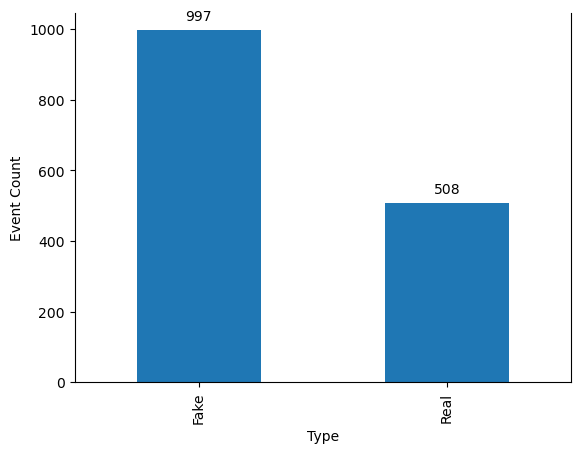

In [4]:
# Bar plot comparison of number of events in each type
ax = df.groupby('type')['event_id'].count().plot(kind='bar')

# Add labels to the plot
plt.xlabel('Type')
plt.ylabel('Event Count')

# Remove the top spine
ax.spines['top'].set_visible(False)

# Add the height of each bar as annotation
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

# Change label of x-axis
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()


In [5]:
len(df)

1505

### Histograms

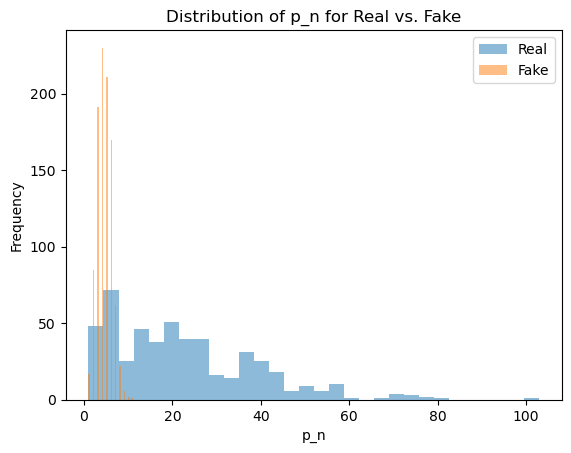

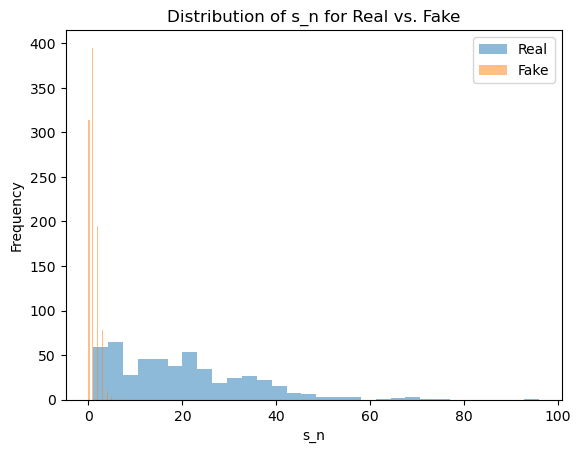

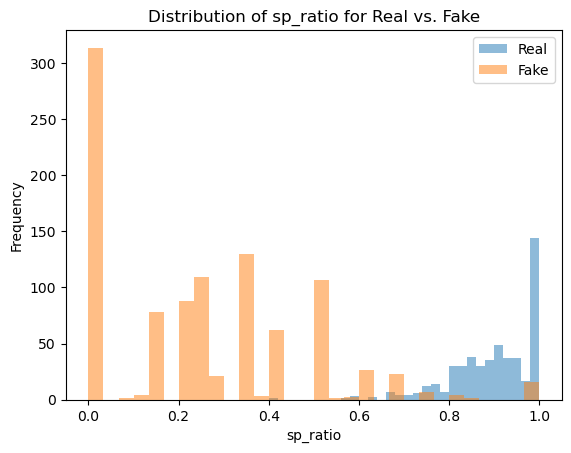

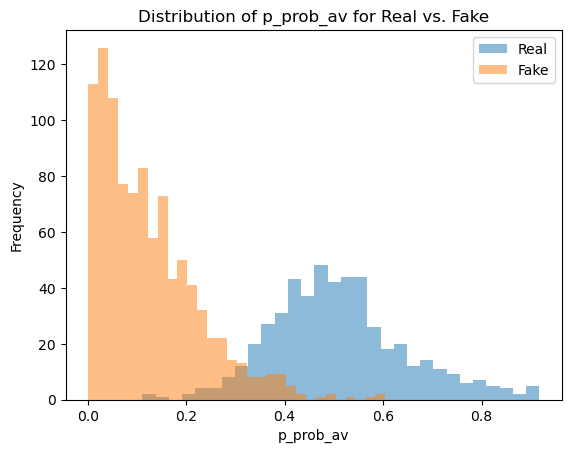

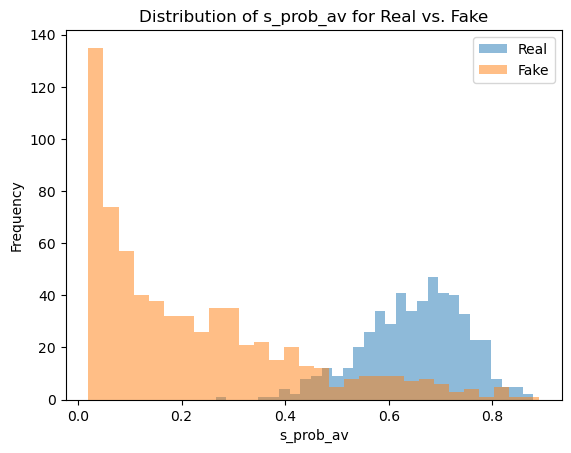

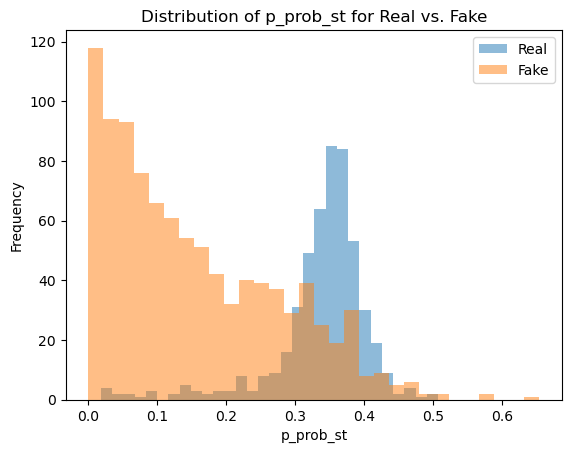

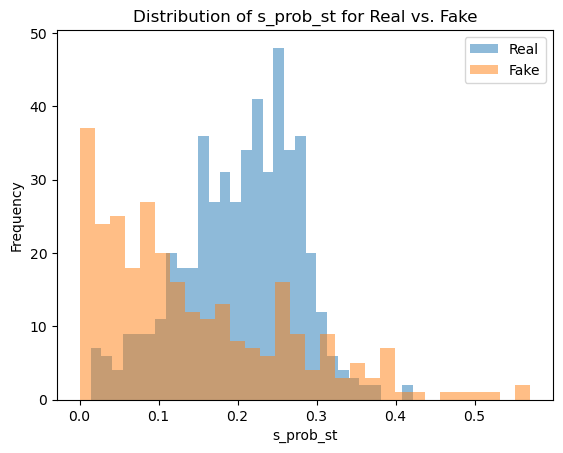

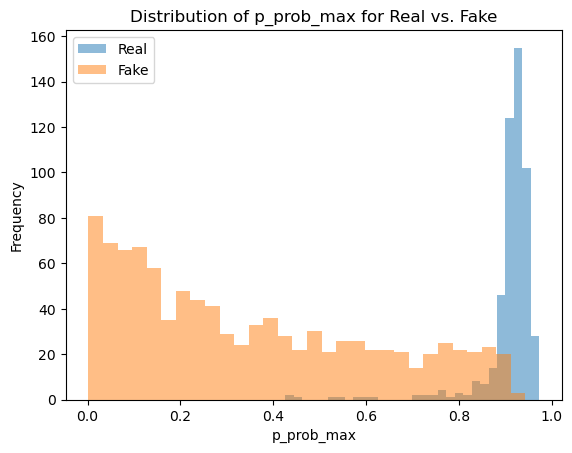

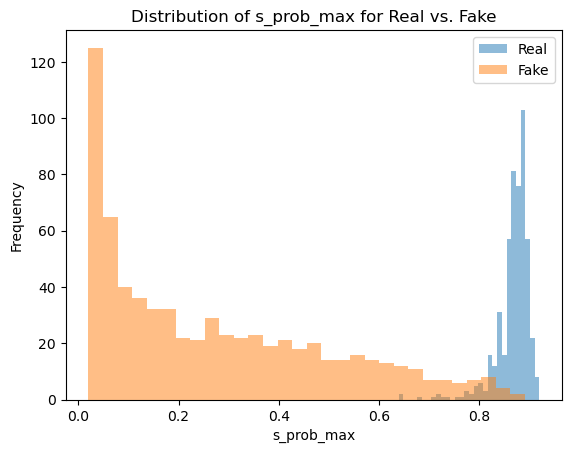

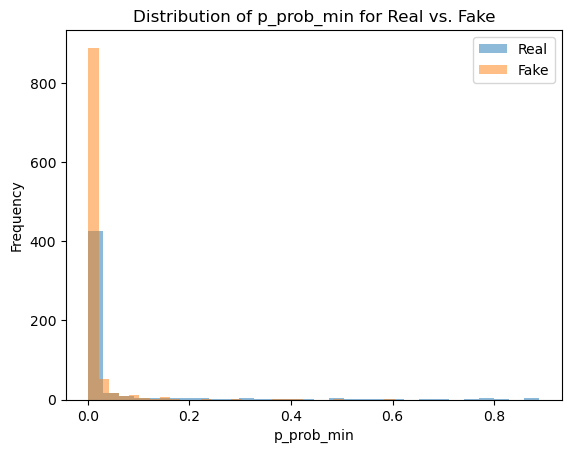

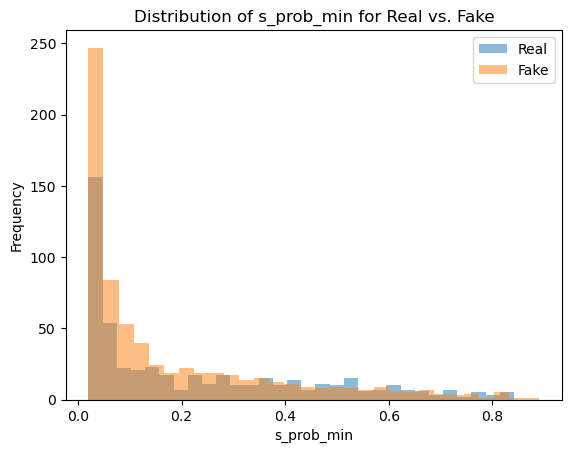

In [6]:
import matplotlib.pyplot as plt

# Plot histograms for each feature
for feature in features:
    plt.figure()
    plt.hist(real_data[feature].dropna(), bins=30, alpha=0.5, label='Real')
    plt.hist(fake_data[feature].dropna(), bins=30, alpha=0.5, label='Fake')
    plt.title(f'Distribution of {feature} for Real vs. Fake')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


### Correlation Heatmap

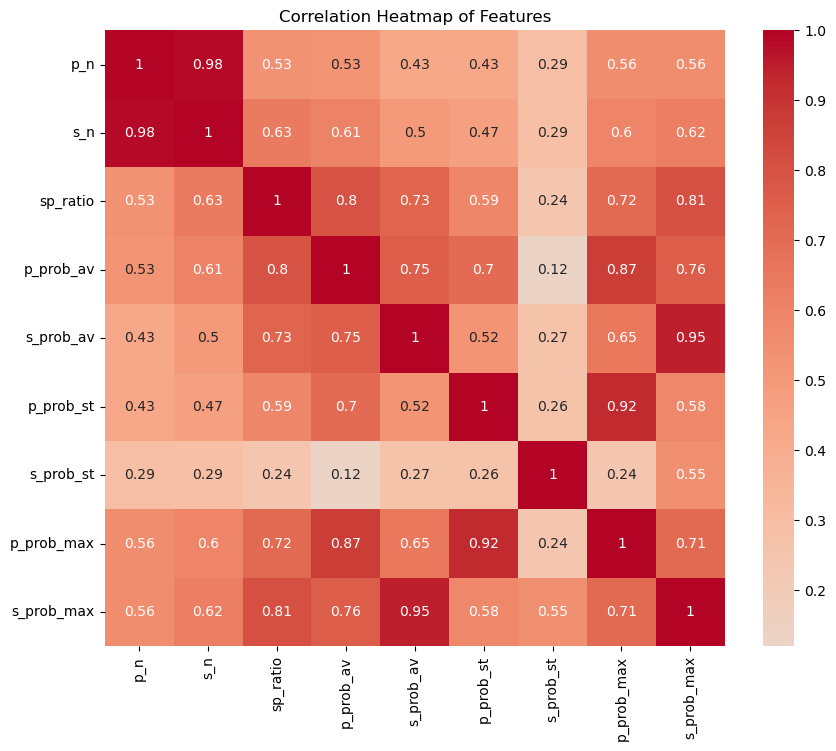

In [7]:
import seaborn as sns
plt.figure(figsize=(10, 8))
features = ['p_n', 's_n', 'sp_ratio', 'p_prob_av', 's_prob_av', 'p_prob_st', 
            's_prob_st', 'p_prob_max', 's_prob_max']
corr = df[features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Features')
plt.show()

In [8]:
df.head()

,event_id,type,p_n,s_n,sp_ratio,p_prob_av,s_prob_av,p_prob_st,s_prob_st,p_prob_max,s_prob_max,p_prob_min,s_prob_min
0,texnet2024ipoe,1,5,5,1.000000,0.329200,0.618600,0.390705,0.188872,0.829,0.787,0.006,0.386
1,texnet2024irwk,1,28,25,0.892857,0.561179,0.791240,0.333318,0.112417,0.910,0.887,0.002,0.384
2,texnet2024irxi,1,36,33,0.916667,0.438806,0.610545,0.353572,0.209404,0.945,0.854,0.001,0.025
3,texnet2024ivnd,1,5,5,1.000000,0.911400,0.810600,0.026651,0.055406,0.950,0.873,0.886,0.750
4,texnet2024iwzt,1,17,14,0.823529,0.389824,0.569214,0.362664,0.315887,0.940,0.868,0.002,0.025


### Principal Component Analysis (PCA)

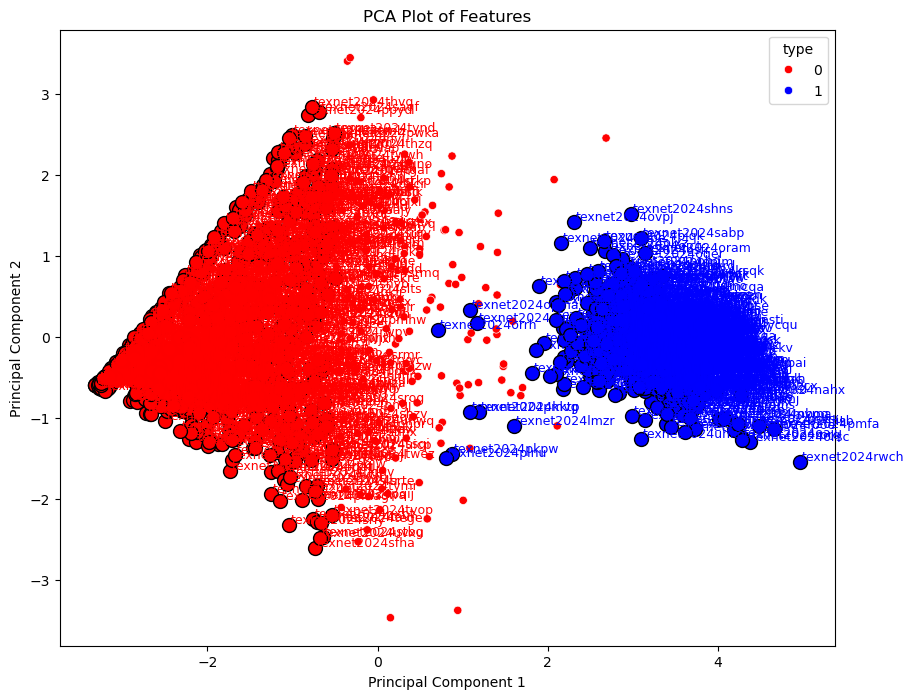

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming df is already defined and contains 'event_id' column and the data

# Fill NaNs with 0
df.fillna(0, inplace=True)

# Select features and target
features = ['p_n', 'sp_ratio', 'p_prob_av', 's_prob_av', 'p_prob_st', 
            's_prob_st', 'p_prob_max', 's_prob_max']
X = df[features]  # Features for PCA
y = df['type']    # Target (real vs. fake)
event_ids = df['event_id']  # Event IDs to track

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['type'] = y
pca_df['event_id'] = event_ids

# Plotting all points with hue based on type
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='type', data=pca_df, palette=['red', 'blue'])
plt.title('PCA Plot of Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Filtering for red points (type 0) with PC1 > 0
red_points = pca_df[(pca_df['type'] == 0) & (pca_df['PC1'] < -0.5)]

# Filtering for blue points (type 1) with PC1 < 0
blue_points = pca_df[(pca_df['type'] == 1) & (pca_df['PC1'] > -0.5)]

# Plot and annotate red points with event_id
for _, row in red_points.iterrows():
    plt.scatter(row['PC1'], row['PC2'], color='red', edgecolor='black', s=100, marker='o')
    plt.text(row['PC1'] + 0.02, row['PC2'] + 0.02, str(row['event_id']), fontsize=9, color='red')

# Plot and annotate blue points with event_id
for _, row in blue_points.iterrows():
    plt.scatter(row['PC1'], row['PC2'], color='blue', edgecolor='black', s=100, marker='o')
    plt.text(row['PC1'] + 0.02, row['PC2'] + 0.02, str(row['event_id']), fontsize=9, color='blue')

plt.show()


# Random Forest classifier

Precision: 1.00
Recall: 0.99
F1 Score: 0.99


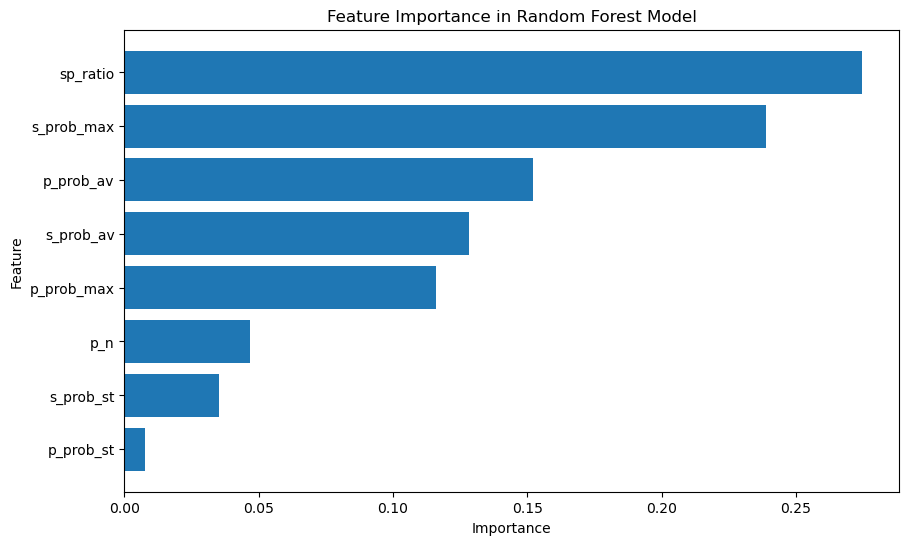

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the combined dataset
df = pd.read_csv(conbined_real_fake_csv)
df.fillna(0, inplace=True)

# Specify the features and the target variable
features = ['p_n', 'sp_ratio', 'p_prob_av', 's_prob_av', 'p_prob_st', 
            's_prob_st', 'p_prob_max', 's_prob_max']
X = df[features]
y = df['type']
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.replace([np.inf, -np.inf], np.nan).dropna()
# Standardize the features for better performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Get feature importances from the model
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# evaluate the model, get precision, recall, f1 score
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)

from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


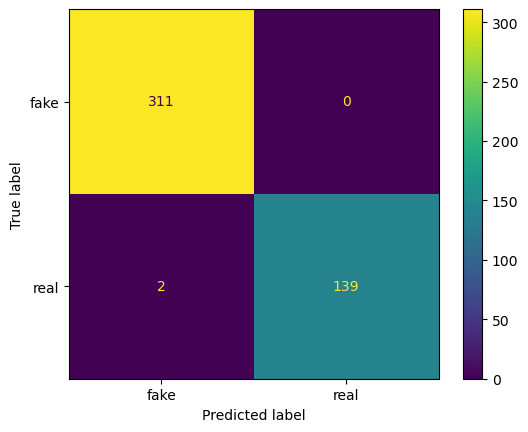

In [11]:
# print confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['fake', 'real'])
disp.plot()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


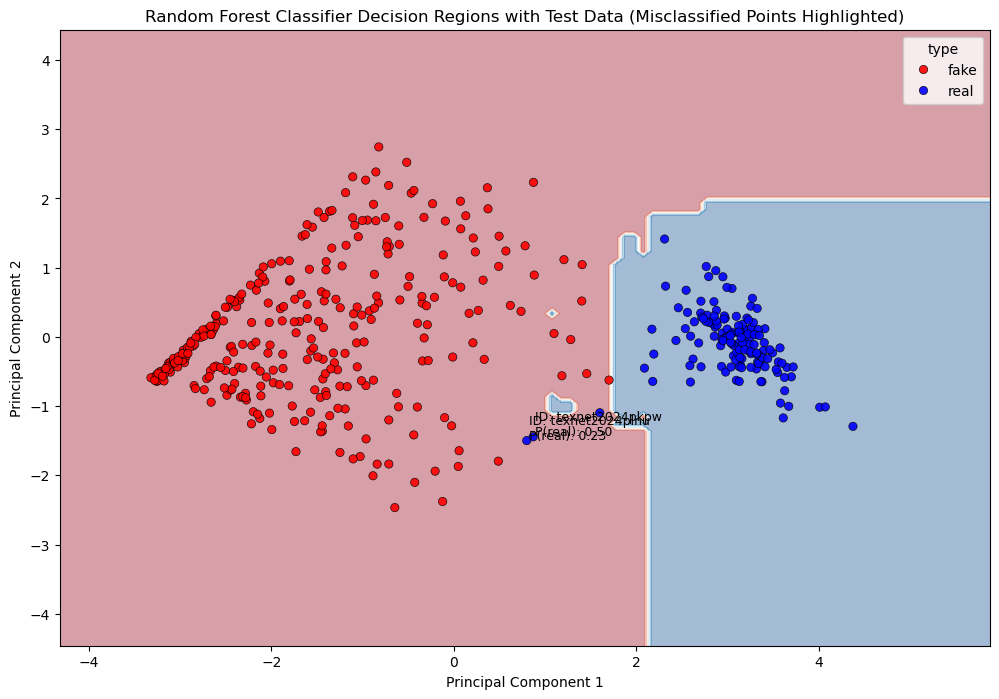

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

# Load the combined dataset
df = pd.read_csv(conbined_real_fake_csv)
df.fillna(0, inplace=True)

# Specify the features and the target variable
X = df[features]
y = df['type']
event_ids = df['event_id']  # Store event_id to track points

# Remove NaNs and Infs
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]  # Keep y in sync with X after dropping NaNs
event_ids = event_ids.loc[X.index]

# Standardize the features for better performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce dimensions to 2 using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for easy tracking of points
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['type'] = y
pca_df['event_id'] = event_ids

# Split into training and testing sets
X_train, X_test, y_train, y_test, event_id_train, event_id_test = train_test_split(
    pca_df[['PC1', 'PC2']], y, event_ids, test_size=0.3, random_state=42)

# Train the Random Forest model in the reduced 2D space
rf_model_pca = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model_pca.fit(X_train, y_train)

# Predict on the test set and get probabilities
# y_pred = rf_model_pca.predict(X_test)
# y_pred_proba = rf_model_pca.predict_proba(X_test)

# Find misclassified points
misclassified = (y_test != y_pred)

# Plot decision boundaries
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict the label for each point in the mesh
Z = rf_model_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(12, 8))

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu')

y_test_labels = y_test.replace({0: 'fake', 1: 'real'})
# Plot test data points
sns.scatterplot(x=X_test['PC1'], y=X_test['PC2'], hue=y_test_labels, palette=['red', 'blue'], hue_order=['fake', 'real'], alpha=0.9, edgecolor='k')

# Highlight misclassified points and annotate with event_id and probabilities
misclassified_points = X_test[misclassified].reset_index()
misclassified_event_ids = event_id_test[misclassified].reset_index(drop=True)
misclassified_probs = y_pred_proba[misclassified]

for i, row in misclassified_points.iterrows():
    event_id = misclassified_event_ids[i]
    prob_real = misclassified_probs[i, 1]  # Probability of being "real"
    plt.text(
        row['PC1'] + 0.02, row['PC2'] + 0.02,
        f"ID: {event_id}\nP(real): {prob_real:.2f}",
        fontsize=9, color='black'
    )

# Titles and labels
plt.title('Random Forest Classifier Decision Regions with Test Data (Misclassified Points Highlighted)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [13]:
# Check PCA explained variance
explained_variance = pca.explained_variance_ratio_
print(f'Explained Variance by PCA components: {explained_variance}')
print(f'Total explained variance: {sum(explained_variance)}')

Explained Variance by PCA components: [0.71993374 0.0974172 ]
Total explained variance: 0.8173509457311222


## Random Forest 2 variables

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Precision: 1.00
Recall: 0.99
F1 Score: 0.99
ID: texnet2024plty, P(real): 0.43, IDX: 0
ID: texnet2024oymy, P(real): 0.43, IDX: 1


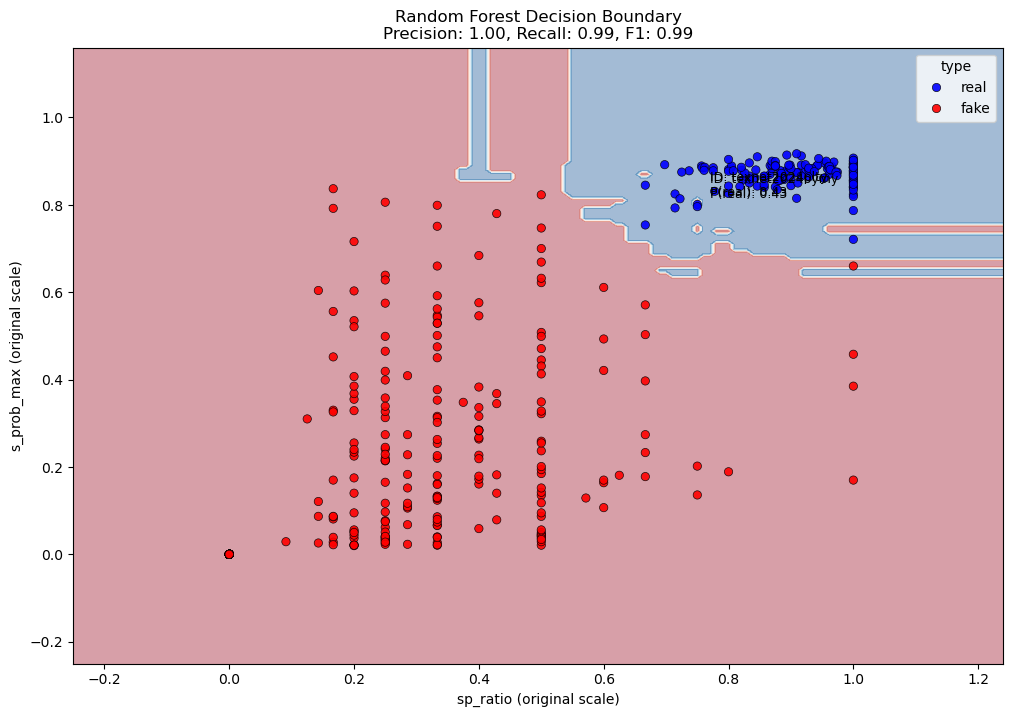

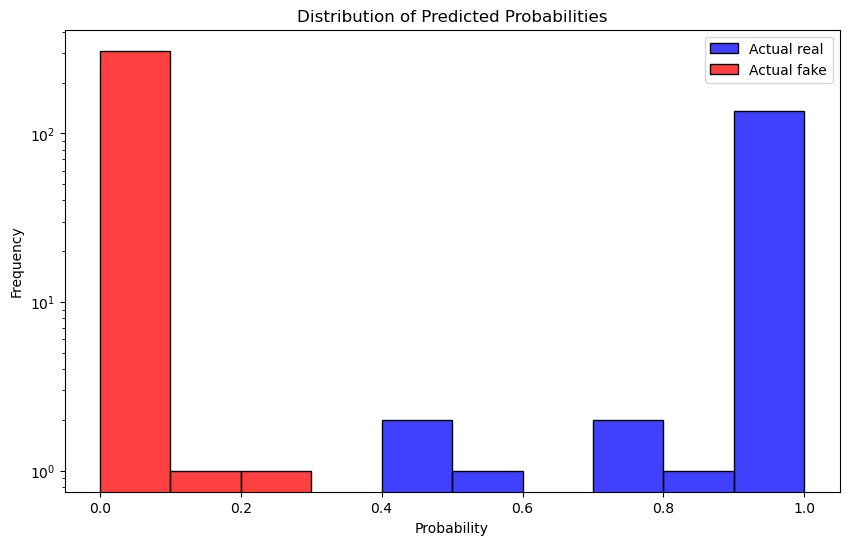

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score

# Load your dataset
df = pd.read_csv(conbined_real_fake_csv)
df.fillna(0, inplace=True)

# Specify features and target
features = ['sp_ratio', 's_prob_max']
X = df[features]
y = df['type']
event_ids = df['event_id']  # Assuming there's an 'event_id' column to track IDs

# Remove infinities and drop rows with NaN
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]  # Keep y and event_ids in sync with X after dropping rows
event_ids = event_ids.loc[X.index]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test split
X_train_scaled, X_test_scaled, y_train, y_test, event_ids_train, event_ids_test = train_test_split(
    X_scaled, y, event_ids, test_size=0.3, random_state=42
)

# Random Forest training
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)  # Get probabilities

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Identify misclassified points
misclassified = (y_test != y_pred)
X_test_misclassified = X_test_scaled[misclassified]
event_ids_misclassified = event_ids_test[misclassified]
probs_misclassified = y_pred_proba[misclassified]

# Inverse-transform the test set to original coordinates for plotting
X_test_original = scaler.inverse_transform(X_test_scaled)

# Handle case with no misclassified points
if len(X_test_misclassified) > 0:
    X_test_misclassified_original = scaler.inverse_transform(X_test_misclassified)
else:
    X_test_misclassified_original = np.empty((0, 2))

# Replace 0 and 1 with 'fake' and 'real' in y_test for plotting
y_test_labels = y_test.replace({0: 'fake', 1: 'real'})

# --------------------------
# Plot decision boundary
# --------------------------

# 1. Create meshgrid in ORIGINAL coordinates
x_min, x_max = X['sp_ratio'].min() - 0.25, X['sp_ratio'].max() + 0.25
y_min, y_max = X['s_prob_max'].min() - 0.25, X['s_prob_max'].max() + 0.25
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# 2. Scale the mesh points for prediction
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_points_scaled = scaler.transform(grid_points)
Z = rf_model.predict(grid_points_scaled)
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu')

# Scatterplot in original space
sns.scatterplot(
    x=X_test_original[:, 0],
    y=X_test_original[:, 1],
    hue=y_test_labels,  # Use labeled data
    palette={'fake': 'red', 'real': 'blue'},  # Ensure consistent colors
    alpha=0.9,
    edgecolor='k'
)

# Annotate misclassified points with event IDs and probabilities (if any exist)
if len(X_test_misclassified_original) > 0:
    for idx, (x, y) in enumerate(X_test_misclassified_original):
        event_id = event_ids_misclassified.iloc[idx]
        prob_real = probs_misclassified[idx, 1]  # Probability of being "real"
        plt.text(
            x + 0.02, y + 0.02,
            f"ID: {event_id}\nP(real): {prob_real:.2f}",
            fontsize=9, color='black'
        )
        print(f"ID: {event_id}, P(real): {prob_real:.2f}, IDX: {idx}")

plt.title(f'Random Forest Decision Boundary\nPrecision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}')
plt.xlabel('sp_ratio (original scale)')
plt.ylabel('s_prob_max (original scale)')
plt.show()

# --------------------------
# Plot the distribution of probabilities
# --------------------------
# keep only the ones classified as real
y_pred_proba_selected = y_pred_proba[y_test == 1]
y_pred_proba_selected_false = y_pred_proba[y_test == 0]
plt.figure(figsize=(10, 6))
#sns.histplot(y_pred_proba[:, 1], bins=20, kde=True, color='blue', label='P(real)')
sns.histplot(y_pred_proba_selected[:, 1], bins=np.arange(0, 1.1, 0.1), kde=False, color='blue', label='Actual real')
sns.histplot(y_pred_proba_selected_false[:, 1], bins=np.arange(0, 1.1, 0.1), kde=False, color='red', label='Actual fake')
# y-axis in log scale
plt.yscale('log')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# print IDX of real predicted fake
# idx = np.where(y_pred_proba[:, 1] <= 0.5)[0]
# print(idx)

1053 452 1053 452 1053 452


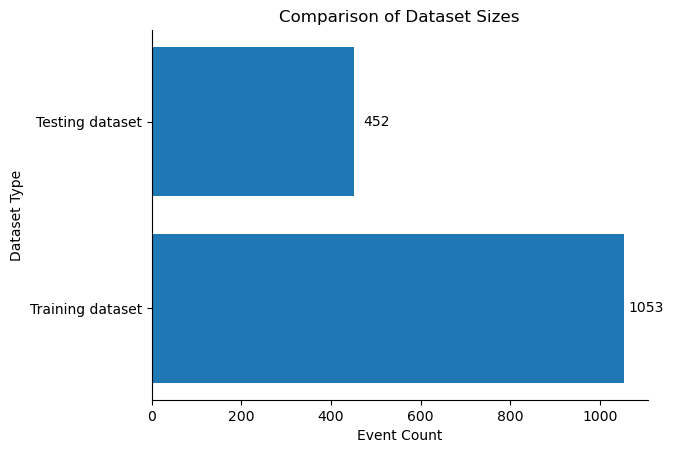

In [15]:
#X_train_scaled, X_test_scaled, y_train, y_test, event_ids_train, event_ids_test

print(len(X_train_scaled), len(X_test_scaled), len(y_train), len(y_test), len(event_ids_train), len(event_ids_test))

import matplotlib.pyplot as plt

# Data
counts = [len(X_train_scaled), len(X_test_scaled)]  # Values for the bars
labels = ['Training dataset', 'Testing dataset']  # Labels for the bars

# Create a horizontal bar plot
fig, ax = plt.subplots()
ax.barh(labels, counts)

# Add annotations for the counts
for i, v in enumerate(counts):
    ax.text(v + 50, i, str(v), ha='center', va='center')

# Add labels and title
plt.xlabel('Event Count')
plt.ylabel('Dataset Type')
plt.title('Comparison of Dataset Sizes')

# Remove the top spine
ax.spines['top'].set_visible(False)
# Remove the right spine
ax.spines['right'].set_visible(False)

plt.show()

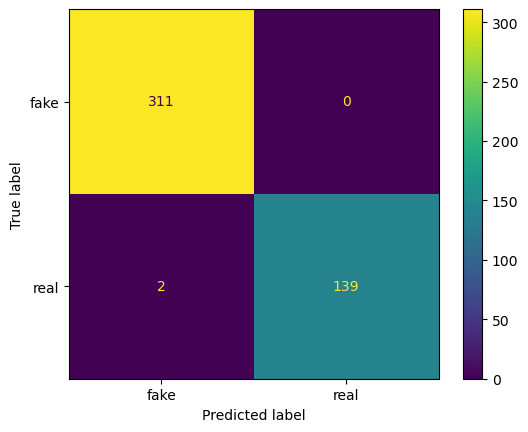

In [16]:
# print confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['fake', 'real'])
disp.plot()
plt.show()

# XGBoost

### XGBoost using PCA

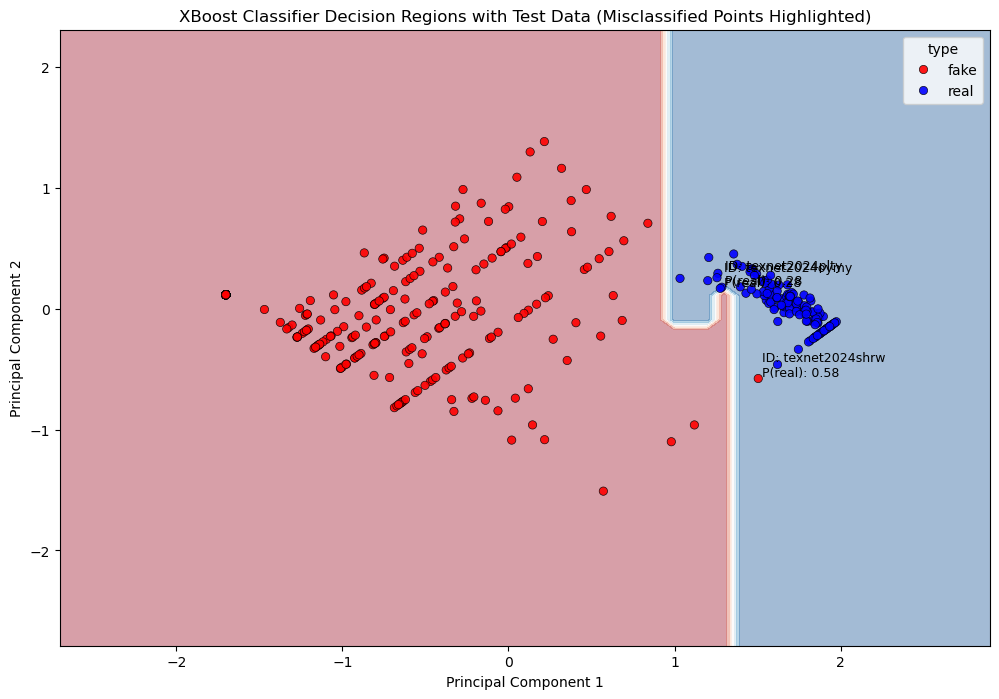

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from xgboost import XGBClassifier

# Load the combined dataset
df = pd.read_csv(conbined_real_fake_csv)
df.fillna(0, inplace=True)

# Specify the features and the target variable
X = df[features]
y = df['type']
event_ids = df['event_id']  # Store event_id to track points

# Remove NaNs and Infs
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]  # Keep y in sync with X after dropping NaNs
event_ids = event_ids.loc[X.index]

# Standardize the features for better performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce dimensions to 2 using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for easy tracking of points
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['type'] = y
pca_df['event_id'] = event_ids

# Split into training and testing sets
X_train, X_test, y_train, y_test, event_id_train, event_id_test = train_test_split(
    pca_df[['PC1', 'PC2']], y, event_ids, test_size=0.3, random_state=42)

# Train the Random Forest model in the reduced 2D space
xgb_model_pca = XGBClassifier(random_state=42, n_estimators=100)
xgb_model_pca.fit(X_train, y_train)

# Predict on the test set and get probabilities
y_pred = xgb_model_pca.predict(X_test)
y_pred_proba = xgb_model_pca.predict_proba(X_test)

# Find misclassified points
misclassified = (y_test != y_pred)

# Plot decision boundaries
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict the label for each point in the mesh
Z = xgb_model_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(12, 8))

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu')

y_test_labels = y_test.replace({0: 'fake', 1: 'real'})
# Plot test data points
sns.scatterplot(x=X_test['PC1'], y=X_test['PC2'], hue=y_test_labels, palette=['red', 'blue'], hue_order=['fake', 'real'], alpha=0.9, edgecolor='k')

# Highlight misclassified points and annotate with event_id and probabilities
misclassified_points = X_test[misclassified].reset_index()
misclassified_event_ids = event_id_test[misclassified].reset_index(drop=True)
misclassified_probs = y_pred_proba[misclassified]

for i, row in misclassified_points.iterrows():
    event_id = misclassified_event_ids[i]
    prob_real = misclassified_probs[i, 1]  # Probability of being "real"
    plt.text(
        row['PC1'] + 0.02, row['PC2'] + 0.02,
        f"ID: {event_id}\nP(real): {prob_real:.2f}",
        fontsize=9, color='black'
    )

# Titles and labels
plt.title('XBoost Classifier Decision Regions with Test Data (Misclassified Points Highlighted)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

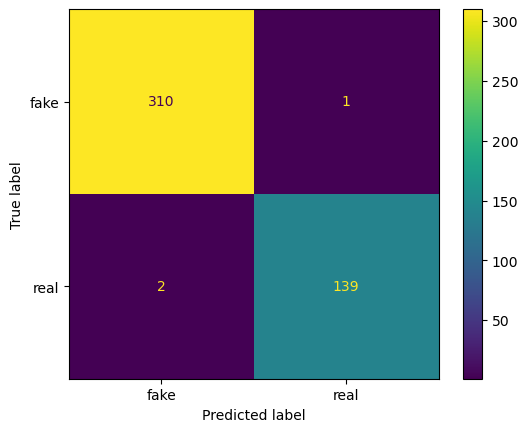

In [18]:
# print confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['fake', 'real'])
disp.plot()
plt.show()

# XGBoost with 2 variables

Precision: 1.00
Recall: 1.00
F1 Score: 1.00


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:08:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


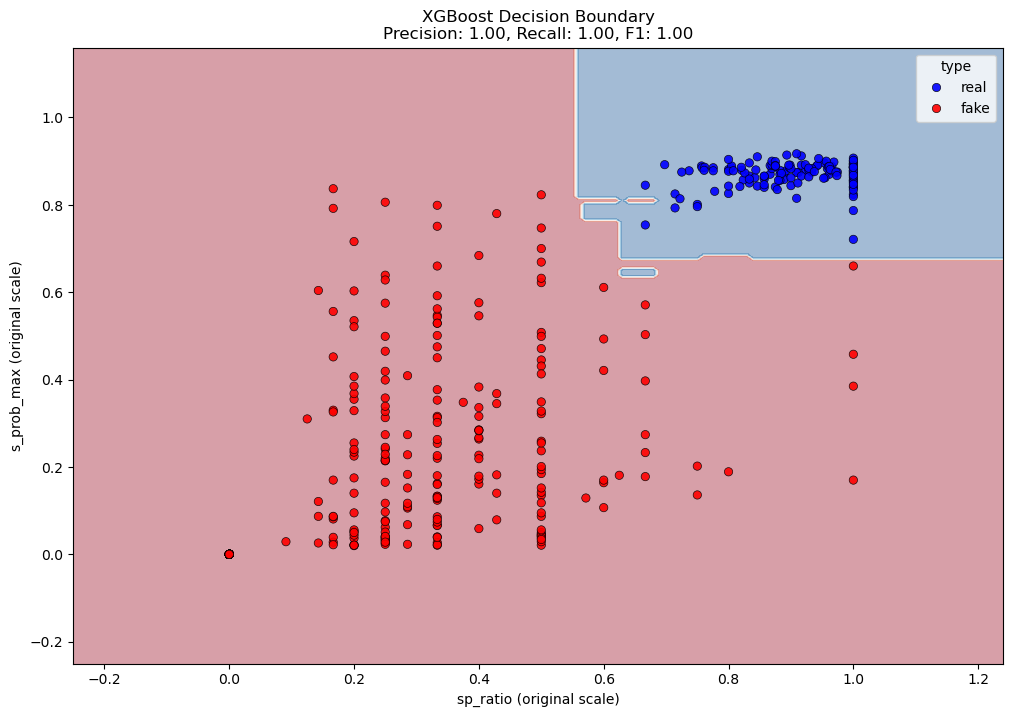

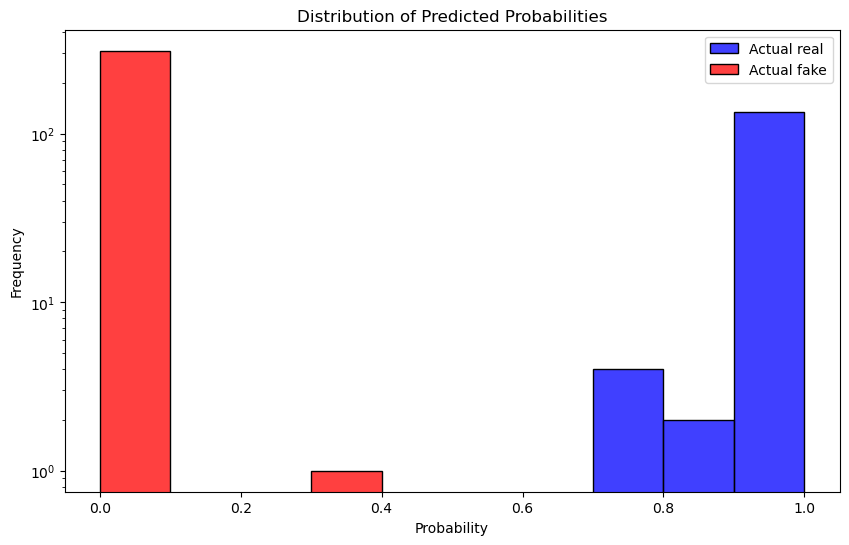

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from xgboost import XGBClassifier

# Load your dataset
df = pd.read_csv(conbined_real_fake_csv)
df.fillna(0, inplace=True)

# Specify features and target
features = ['sp_ratio', 's_prob_max']
X = df[features]
y = df['type']
event_ids = df['event_id']  # Assuming there's an 'event_id' column to track IDs

# Remove infinities and drop rows with NaN
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]  # Keep y and event_ids in sync with X after dropping rows
event_ids = event_ids.loc[X.index]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test split
X_train_scaled, X_test_scaled, y_train, y_test, event_ids_train, event_ids_test = train_test_split(
    X_scaled, y, event_ids, test_size=0.3, random_state=42
)

# XGBoost training
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_estimators=30)
xgb_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = xgb_model.predict(X_test_scaled)
y_pred_proba = xgb_model.predict_proba(X_test_scaled)  # Get probabilities

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Identify misclassified points
misclassified = (y_test != y_pred)
X_test_misclassified = X_test_scaled[misclassified]
event_ids_misclassified = event_ids_test[misclassified]
probs_misclassified = y_pred_proba[misclassified]

# Inverse-transform the test set to original coordinates for plotting
X_test_original = scaler.inverse_transform(X_test_scaled)

# Handle case with no misclassified points
if len(X_test_misclassified) > 0:
    X_test_misclassified_original = scaler.inverse_transform(X_test_misclassified)
else:
    X_test_misclassified_original = np.empty((0, 2))

# Replace 0 and 1 with 'fake' and 'real' in y_test for plotting
y_test_labels = y_test.replace({0: 'fake', 1: 'real'})

# --------------------------
# Plot decision boundary
# --------------------------

# 1. Create meshgrid in ORIGINAL coordinates
x_min, x_max = X['sp_ratio'].min() - 0.25, X['sp_ratio'].max() + 0.25
y_min, y_max = X['s_prob_max'].min() - 0.25, X['s_prob_max'].max() + 0.25
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# 2. Scale the mesh points for prediction
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_points_scaled = scaler.transform(grid_points)
Z = xgb_model.predict(grid_points_scaled)
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu')

# Scatterplot in original space
sns.scatterplot(
    x=X_test_original[:, 0],
    y=X_test_original[:, 1],
    hue=y_test_labels,  # Use labeled data
    palette={'fake': 'red', 'real': 'blue'},  # Ensure consistent colors
    alpha=0.9,
    edgecolor='k'
)

# Annotate misclassified points with event IDs and probabilities (if any exist)
if len(X_test_misclassified_original) > 0:
    for idx, (x, y) in enumerate(X_test_misclassified_original):
        event_id = event_ids_misclassified.iloc[idx]
        prob_real = probs_misclassified[idx, 1]  # Probability of being "real"
        plt.text(
            x + 0.02, y + 0.02,
            #f"ID: {event_id}\nP(real): {prob_real:.2f}",
            f"ID: {event_id}",
            fontsize=9, color='black'
        )
        print(f"ID: {event_id}, P(real): {prob_real:.2f}, idx: {idx}")

plt.title(f'XGBoost Decision Boundary\nPrecision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}')
plt.xlabel('sp_ratio (original scale)')
plt.ylabel('s_prob_max (original scale)')
plt.show()

# --------------------------
# Plot the distribution of probabilities
# --------------------------
# keep only the ones classified as real
y_pred_proba_selected = y_pred_proba[y_test == 1]
y_pred_proba_selected_false = y_pred_proba[y_test == 0]
plt.figure(figsize=(10, 6))
#sns.histplot(y_pred_proba[:, 1], bins=20, kde=True, color='blue', label='P(real)')
sns.histplot(y_pred_proba_selected[:, 1], bins=np.arange(0, 1.1, 0.1), kde=False, color='blue', label='Actual real')
sns.histplot(y_pred_proba_selected_false[:, 1], bins=np.arange(0, 1.1, 0.1), kde=False, color='red', label='Actual fake')
# y-axis in log scale
plt.yscale('log')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

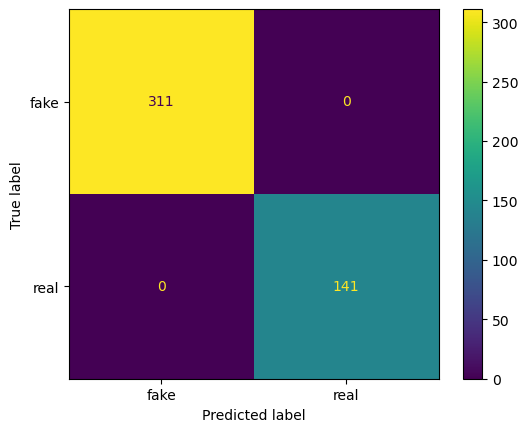

In [20]:
# print confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['fake', 'real'])
disp.plot()
plt.show()

In [21]:
df.query("sp_ratio < 0.5 and s_prob_max > 0.8 and type == 0")

,event_id,type,p_n,s_n,sp_ratio,p_prob_av,s_prob_av,p_prob_st,s_prob_st,p_prob_max,s_prob_max,p_prob_min,s_prob_min
381,texnet2024pnes,0,4,1,0.250000,0.195750,0.806000,0.301976,0.000000,0.640,0.806,0.004,0.806
450,texnet2024prbs,0,4,1,0.250000,0.123000,0.811000,0.205921,0.000000,0.431,0.811,0.002,0.811
626,texnet2024rwiu,0,6,1,0.166667,0.075500,0.837000,0.108524,0.000000,0.284,0.837,0.001,0.837
789,texnet2024shdw,0,7,3,0.428571,0.258714,0.450667,0.289274,0.384513,0.719,0.837,0.003,0.068
836,texnet2024siur,0,5,1,0.200000,0.111600,0.823000,0.218644,0.000000,0.502,0.823,0.001,0.823
960,texnet2024srml,0,6,2,0.333333,0.156833,0.450500,0.326526,0.567807,0.821,0.852,0.001,0.049


In [22]:
df.query("sp_ratio > 0.55 and s_prob_max > 0.6 and type == 0")

,event_id,type,p_n,s_n,sp_ratio,p_prob_av,s_prob_av,p_prob_st,s_prob_st,p_prob_max,s_prob_max,p_prob_min,s_prob_min
276,texnet2024plds,0,5,3,0.600000,0.118600,0.631333,0.208482,0.294833,0.487,0.809,0.002,0.291
359,texnet2024pmwr,0,5,3,0.600000,0.139400,0.311000,0.173190,0.345987,0.436,0.710,0.014,0.094
418,texnet2024polz,0,10,8,0.800000,0.316300,0.421375,0.282851,0.155020,0.766,0.659,0.003,0.234
553,texnet2024qzhv,0,4,3,0.750000,0.200250,0.278000,0.225448,0.314005,0.444,0.628,0.008,0.021
684,texnet2024rzms,0,3,3,1.000000,0.295000,0.327667,0.435790,0.460158,0.798,0.859,0.031,0.059
808,texnet2024shrw,0,3,3,1.000000,0.483667,0.596667,0.119006,0.074895,0.602,0.660,0.364,0.514
969,texnet2024srnl,0,4,3,0.750000,0.424250,0.600333,0.481418,0.342462,0.884,0.806,0.005,0.205
985,texnet2024srry,0,3,2,0.666667,0.057667,0.468500,0.074574,0.570635,0.143,0.872,0.005,0.065
1050,texnet2024stth,0,5,3,0.600000,0.066200,0.264000,0.093387,0.308219,0.226,0.611,0.002,0.022
1064,texnet2024taqj,0,5,3,0.600000,0.242200,0.287333,0.343362,0.308147,0.830,0.630,0.001,0.033


In [23]:
event_ids_train.shape

(1053,)

In [24]:
y_pred_proba[0, 0]

0.002265215